In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import IsolationForest
from wordcloud import WordCloud

In [83]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import warnings

warnings.filterwarnings('ignore')

In [84]:
df=pd.read_csv("ds_salaries.csv")

In [85]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [86]:
print(df.shape)

(3755, 11)


In [87]:
df.nunique()

work_year                4
experience_level         4
employment_type          4
job_title               93
salary                 815
salary_currency         20
salary_in_usd         1035
employee_residence      78
remote_ratio             3
company_location        72
company_size             3
dtype: int64

In [88]:
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [89]:
df.duplicated().sum()

1171

In [90]:
df = df.drop_duplicates()

In [91]:
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [92]:
numerical_columns=df.select_dtypes(include=['int64']).columns
categorical_columns=df.select_dtypes(include=['object']).columns

In [93]:
numerical_columns

Index(['work_year', 'salary', 'salary_in_usd', 'remote_ratio'], dtype='object')

In [94]:
categorical_columns

Index(['experience_level', 'employment_type', 'job_title', 'salary_currency',
       'employee_residence', 'company_location', 'company_size'],
      dtype='object')

In [95]:
print(df.columns)
df.columns = df.columns.str.strip()

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')


In [96]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,2584.000000,2.584000e+03,2584.000000,2584.000000
mean,2022.301084,2.103653e+05,133409.280186,50.483746
std,0.749179,8.080375e+05,67136.837329,48.163707
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,9.000000e+04,84975.000000,0.000000
50%,2022.000000,1.346300e+05,130000.000000,50.000000
75%,2023.000000,1.825625e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [97]:
# Function to identify outliers in numerical columns
def identify_numerical_outliers(df, numerical_columns, contamination=0.05, random_state=42):
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)
    outliers = iso_forest.fit_predict(df[numerical_columns])
    
    # Mark numerical outliers as True where outliers == -1
    df['numerical_outlier'] = (outliers == -1)
    
    return df

# Function to identify outliers in categorical columns based on frequency threshold
def identify_categorical_outliers(df, categorical_columns, threshold=0.01):
    outlier_flags = pd.DataFrame(index=df.index)
    
    for col in categorical_columns:
        freq = df[col].value_counts(normalize=True)
        rare_values = freq[freq < threshold].index
        
        # Mark categorical outliers as True if the value is in the rare list
        outlier_flags[f'{col}_outlier'] = df[col].isin(rare_values)
    
    # Combine all categorical outliers into a single column
    df['categorical_outlier'] = outlier_flags.any(axis=1)
    
    return df


# Identify numerical and categorical columns in the dataset
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Identify numerical outliers
df = identify_numerical_outliers(df, numerical_columns)

# Identify categorical outliers (e.g., less than 1% frequency)
df = identify_categorical_outliers(df, categorical_columns, threshold=0.01)

# Print results
numerical_outlier_percentage = (df['numerical_outlier'].sum() / len(df)) * 100
categorical_outlier_percentage = (df['categorical_outlier'].sum() / len(df)) * 100

print(f"Percentage of numerical outliers: {numerical_outlier_percentage:.2f}%")
print(f"Percentage of categorical outliers: {categorical_outlier_percentage:.2f}%")


Percentage of numerical outliers: 5.03%
Percentage of categorical outliers: 24.57%


### Basic Data Preprocessing

In [98]:
df['salary_category'] = pd.cut(
    df['salary_in_usd'],
    bins=[0, 100000, 200000, float('inf')],
    labels=['salary<100,000 USD', '100,000≤salary<200,000 USD', 'salary≥200,000 USD']
)

df[['salary_in_usd', 'salary_category']].head()


,salary_in_usd,salary_category
0,85847,"salary<100,000 USD"
1,30000,"salary<100,000 USD"
2,25500,"salary<100,000 USD"
3,175000,"100,000≤salary<200,000 USD"
4,120000,"100,000≤salary<200,000 USD"


In [99]:
def ratio_class(ratio):
    if ratio == 100:
        return 'Remote'
    elif ratio == 0:
        return 'In-Person'
    else:
        return 'Hybrid'

In [100]:
df['ratio_class'] = df['remote_ratio'].apply(ratio_class)
df['ratio_class'].value_counts()

ratio_class
Remote       1211
In-Person    1186
Hybrid        187
Name: count, dtype: int64

In [101]:
# Experience level
df['experience_level'] = df['experience_level'].replace(
    {'EN': 'Entry-Level',
     'MI': 'Mid-Level',
     'SE': 'Senior',
     'EX': 'Executive'} 
)

# Company Size
df['company_size'] = df['company_size'].replace(
    {'S': 'Small',
     'M': 'Medium',
     'L': 'Large'}
)

In [102]:
def assign_broader_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]
    
    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

df['job_category'] = df['job_title'].apply(assign_broader_category)

In [103]:
df.drop(['salary_in_usd','job_title','remote_ratio','salary'],axis=1,inplace= True)
df.head()

,work_year,experience_level,employment_type,salary_currency,employee_residence,company_location,company_size,numerical_outlier,categorical_outlier,salary_category,ratio_class,job_category
0,2023,Senior,FT,EUR,ES,ES,Large,False,True,"salary<100,000 USD",Remote,Other
1,2023,Mid-Level,CT,USD,US,US,Small,False,True,"salary<100,000 USD",Remote,Machine Learning
2,2023,Mid-Level,CT,USD,US,US,Small,False,True,"salary<100,000 USD",Remote,Machine Learning
3,2023,Senior,FT,USD,CA,CA,Medium,False,False,"100,000≤salary<200,000 USD",Remote,Data Science
4,2023,Senior,FT,USD,CA,CA,Medium,False,False,"100,000≤salary<200,000 USD",Remote,Data Science


In [104]:
from sklearn.preprocessing import OrdinalEncoder

# Initialize the OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[['salary<100,000 USD', '100,000≤salary<200,000 USD', 'salary≥200,000 USD']])

# Fit and transform the salary_category column
df['salary_category_numeric'] = ordinal_encoder.fit_transform(df[['salary_category']]).astype(int) + 1

# Display the result
df[['salary_category', 'salary_category_numeric']].head()


,salary_category,salary_category_numeric
0,"salary<100,000 USD",1
1,"salary<100,000 USD",1
2,"salary<100,000 USD",1
3,"100,000≤salary<200,000 USD",2
4,"100,000≤salary<200,000 USD",2


In [105]:
df.drop(['salary_category',	'numerical_outlier','categorical_outlier'],axis=1,inplace= True)

In [106]:
df = pd.get_dummies(df,columns=['experience_level','salary_currency','employment_type', 'employee_residence', 'company_location', 'company_size','job_category','ratio_class'],dtype=int)

In [107]:
X = df.drop('salary_category_numeric',axis=1)
y = df['salary_category_numeric']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [108]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix 
from collections import Counter
print("Original class distribution:", Counter(y)) 

Original class distribution: Counter({2: 1341, 1: 867, 3: 376})


In [109]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Print the class distribution of the resampled data
print("SMOTE class distribution:", Counter(y_resampled))

# Optional: You can also print the shape of the resampled dataset
print("Resampled X shape:", X_resampled.shape)
print("Resampled y shape:", y_resampled.shape)


SMOTE class distribution: Counter({3: 1081, 1: 1081, 2: 1081})
Resampled X shape: (3243, 191)
Resampled y shape: (3243,)


# Cluster Analysis

In [110]:
from sklearn.model_selection import cross_val_predict, cross_val_score,KFold, RepeatedStratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [111]:
X_resampled

,work_year,experience_level_Entry-Level,experience_level_Executive,experience_level_Mid-Level,experience_level_Senior,salary_currency_AUD,salary_currency_BRL,salary_currency_CAD,salary_currency_CHF,salary_currency_CLP,...,company_size_Small,job_category_Data Architecture,job_category_Data Engineering,job_category_Data Science,job_category_Machine Learning,job_category_Management,job_category_Other,ratio_class_Hybrid,ratio_class_In-Person,ratio_class_Remote
0,2023,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,2022,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,2022,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,2022,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,2022,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3238,2022,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3239,2022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3240,2023,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3241,2022,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


## K-Mean

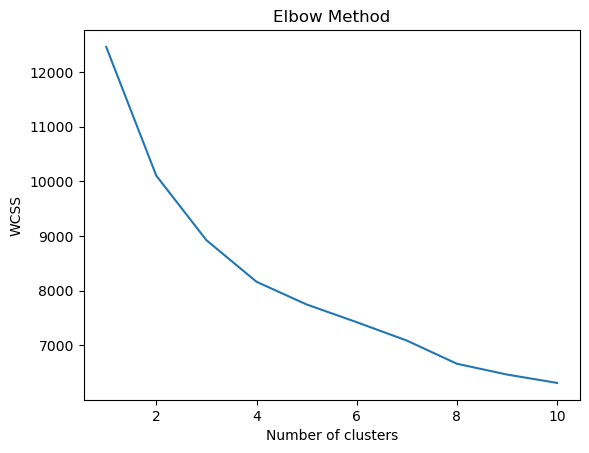

In [112]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_resampled)
    wcss.append(kmeans.inertia_)


plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The average silhouette score is: 0.2939597640033734


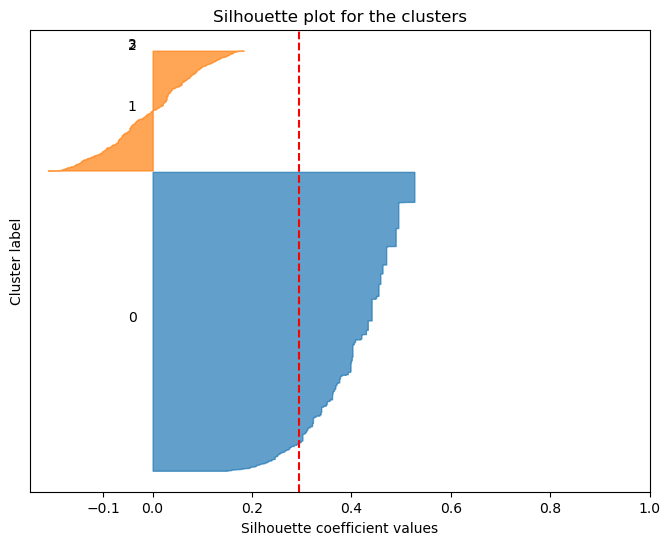

In [113]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_resampled)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
silhouette_avg = silhouette_score(X_resampled, cluster_labels)
print("The average silhouette score is:", silhouette_avg)


sample_silhouette_values = silhouette_samples(X_resampled, cluster_labels)


fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(8, 6)


cluster_colors = sns.color_palette('tab10', n_colors=4)

y_lower = 10
for i in range(4):  
    
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cluster_colors[i]
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    
    y_lower = y_upper + 10  

ax1.set_title("Silhouette plot for the clusters")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")


ax1.axvline(x=silhouette_avg, color="red", linestyle="--")


ax1.set_yticks([])
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


In [114]:
# Count the number of observations in each cluster
cluster_counts = np.bincount(cluster_labels)

# Print the number of observations in each cluster
for i, count in enumerate(cluster_counts):
    print(f"Cluster {i}: {count} observations")

Cluster 0: 2315 observations
Cluster 1: 928 observations
